In [1]:
#Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
import pymysql
import pandas_profiling
import re
from datetime import datetime
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from glom import glom
import ast
import json

In [2]:
%matplotlib inline


# Define an algorithm that allows to price a voice-over project in all of the languages present in the dataset.

**Data Set** 


**user_id:** The unique identifier of the Pro 

**subcategory**: The subcategory to which the rates belong to.

**trusted:** An identifier of how trusted is the pro.

*0=Regular Pros*

*1=Very trustable Pros*

*2=Banned Pros*

**status_submission:** The status of their most recent application test. (labels are self-explanatory)

**language_id:** An identifier of the language of the Pro. 

**seed_data:** A JSON object with the rates. The data is defined in the following units: units (words), time (seconds), cost (rate in local currency of the Pro), costUSD (rate in USD).

**About Pricing** 

Each time a client comes to the website with the intention of quoting or buying a product, they should be able to find the price by themselves without additional help.
Regarding our cost structure, our main costs are the rates that Pros charge us for completing a project. We refer to the payments to freelancers as “rewards”. 

Pros register their rates in a UI for different project lengths within the subcategory/subcategories in which they are signed up. Length refers to the number of units of the project, for example the number of words in a voice over.

**Pricing Requirements**

To guarantee upfront, predictable pricing, the following
requirements must be met:

- Model takes a combination of pricing attributes (language, complexity, etc) and project lengths and returns a price for any length > 0.

- Pros receive the reward they expect.

- X keeps at least the 15% of the project price.

- Fulfillment types also play a role in the pricing, however we will omit that. 

Take into account that each language should have differentiated pricing and that you should be able to have a price for any project between 1 and 50,000 words.

Consider the effect that atypical data points could have in your analysis.

Consider the effect that not having many observations could have on your results.

Deliver a table with the suggested prices for projects of 30, 75, 150 and 500 words in all of the languages present in the dataset.

In max. 300 words explain what you did in plain English. Assume that this will be read by a non-technical stakeholder.

## Solution

### Reasoning

Based on the data I have, I'll model Price (USD) as a function of the pro's cost (USD), and the established minimum margin (15%).

                                    P(cost_usd, min_margin) = cost_usd * (1 + min_margin)
                                  
                                      P(cost_usd, min_margin) = cost_usd * 1.15

According to the UI snapshots displayed in the assignment instructions, pros determine their cost based on the language and the number of words. Moreover, clients get a price by selecting the language, words lenght and age and gender. Since I do not have age and gender data, this will not be part of the analysis.

The cost in USD would also depend on the exchange rate between the local currency and the USD dollar, but for simplicity of the analysis I will ommit that since I don't have data on local currency and their exchange rate.

The dataset includes time(seconds) data, which could also be associated with the voice over complexity and its cost determination. However, the assignment instructions say that I should determine price based on language and number of words, as it is displayed in the UI snapshots. Thus, I will not use time(seconds) data in the analysis, assuming (based on the instructions) that I should not use it to estimate prices. 

Hence, my final output will be an algorithm that determines a Price based on the language and word lenght selected by the client.


                              P(cost_usd, min_margin) =  Cost_usd(language, number of words) * 1.15


According to the UI displayed in the instructions, the client also chooses age, gender and fulfillment time but these are not part of the data set nor in the scope of the assignment.       

I will only use data from Pros with their status_submission equal to "accepted" since I assume that only accepted professionals are able to work in projects. 

Moreover, only data from Pros with their trusted status equal to "Very trustable Pros" or "Regular Pros" will be used. Data from "Banned Pros" will be ignored since I assume they are not allowed to work in projects.

### Data Cleaing

In [3]:
# Reading data
raw_df = pd.read_csv('data/pros_rates_voice.csv')

df = raw_df.copy()

In [4]:
df

,user_id,modified,subcategory,trusted,status_submission,seed_data,language_id
0,0,2019-07-16T13:35:20,voice_over,0,attribute_submission_pending,"{""5000"":{""units"":""5000"",""time"":""300"",""cost"":""2...",vulcan
1,1,2019-08-25T03:00:18,voice_over,2,accepted,"{""50000"":{""time"":null,""cost"":""1205"",""units"":""5...",vulcan
2,2,2016-07-29T15:36:00,voice_over,1,attribute_submission_pending,"{""5000"":{""units"":""5000"",""time"":""45"",""cost"":""50...",vulcan
3,3,2021-01-22T00:01:55,voice_over,1,attribute_submission_pending,"{""5000"":{""units"":""5000"",""time"":""150"",""cost"":""9...",vulcan
4,4,2021-02-02T03:35:03,voice_over,2,accepted,"{""50000"":{""units"":""50000"",""time"":null,""cost"":""...",simlish
...,...,...,...,...,...,...,...
12206,12206,2022-04-29T01:57:45,voice_over,1,accepted,"{""50000"":{""time"":""21600"",""cost"":""1500"",""units""...",vulcan
12207,12207,2022-04-05T07:06:48,voice_over,1,accepted,"{""50000"":{""time"":"""",""cost"":""13875"",""units"":""50...",vulcan
12208,12208,2022-05-09T18:24:24,voice_over,1,accepted,"{""50000"":{""time"":""21600"",""cost"":""300"",""units"":...",simlish
12209,12209,2022-05-03T15:30:12,voice_over,1,accepted,"{""50000"":{""time"":"""",""cost"":""1500"",""units"":""500...",vulcan


In [5]:
# Data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12211 entries, 0 to 12210
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            12211 non-null  int64 
 1   modified           12211 non-null  object
 2   subcategory        12211 non-null  object
 3   trusted            12211 non-null  int64 
 4   status_submission  12207 non-null  object
 5   seed_data          12211 non-null  object
 6   language_id        12211 non-null  object
dtypes: int64(2), object(5)
memory usage: 667.9+ KB


In [6]:
# Checking data types

df.dtypes

user_id               int64
modified             object
subcategory          object
trusted               int64
status_submission    object
seed_data            object
language_id          object
dtype: object

In [7]:

# Checking duplicates

df.duplicated().sum() / len(df)

0.0

In [8]:
# Checking nulls

df.isna().sum() / len(df)

user_id              0.000000
modified             0.000000
subcategory          0.000000
trusted              0.000000
status_submission    0.000328
seed_data            0.000000
language_id          0.000000
dtype: float64

In [9]:
#Checking column values
for column in df.columns:
    print(df[column].value_counts().head(20))
    print(df[column].value_counts().tail(10))
    print()
    print()

0       1
8144    1
8135    1
8136    1
8137    1
8138    1
8139    1
8140    1
8141    1
8142    1
8143    1
8145    1
8133    1
8146    1
8147    1
8148    1
8149    1
8150    1
8151    1
8152    1
Name: user_id, dtype: int64
4067     1
4068     1
4069     1
4070     1
4071     1
4072     1
4073     1
4074     1
4075     1
12210    1
Name: user_id, dtype: int64


2022-05-10T00:15:07    10
2021-12-20T16:50:58    10
2022-05-10T00:15:01     9
2022-05-10T00:15:00     9
2022-05-10T00:10:04     9
2022-05-09T23:55:43     8
2022-05-09T23:55:42     8
2022-05-09T23:55:51     8
2021-12-20T21:40:48     7
2022-05-09T23:57:59     7
2022-05-10T00:11:34     7
2022-05-10T00:01:01     7
2022-05-09T23:58:37     7
2021-12-20T14:31:19     7
2022-05-10T00:11:27     7
2021-12-20T15:50:55     7
2022-05-10T00:08:26     7
2022-05-10T00:18:30     7
2022-05-09T23:56:57     7
2022-05-09T23:56:51     7
Name: modified, dtype: int64
2020-12-17T20:50:27    1
2020-05-30T07:26:14    1
2020-05-28T00:29:33    1
2020-05-

In [10]:
# Only keeping data from Pros with their status_submission equal to "accepted".

df = df.loc[df.status_submission== 'accepted']

In [11]:
# Only keeping data from Pros with their trusted status equal to "Very trustable Pros" or "Regular Pros".

df = df.loc[df.trusted != 2]

In [12]:
#Checking column values
for column in df.columns:
    print(df[column].value_counts().head(20))
    print(df[column].value_counts().tail(10))
    print()
    print()

6       1
8163    1
7929    1
7894    1
7889    1
7861    1
7860    1
7859    1
7847    1
7844    1
7833    1
7828    1
7822    1
7818    1
7811    1
7808    1
7807    1
7781    1
7773    1
7942    1
Name: user_id, dtype: int64
3798     1
3746     1
3795     1
3779     1
3769     1
3768     1
3767     1
3763     1
3753     1
12210    1
Name: user_id, dtype: int64


2022-05-09T23:55:43    6
2022-05-09T23:55:51    5
2021-12-20T02:10:51    5
2021-12-20T06:40:57    4
2021-12-20T09:10:38    4
2021-12-20T01:21:09    4
2022-05-09T23:56:01    4
2021-12-20T02:01:42    4
2022-05-09T23:55:39    4
2021-12-20T02:41:02    4
2021-12-20T00:41:03    4
2021-12-20T07:31:13    4
2021-12-20T00:10:50    3
2021-12-20T03:11:01    3
2021-12-20T05:01:33    3
2021-12-20T04:20:57    3
2021-12-20T01:01:43    3
2022-05-10T00:01:01    3
2022-05-10T00:01:33    3
2021-12-20T04:10:54    3
Name: modified, dtype: int64
2021-12-13T12:19:49    1
2022-04-27T07:16:31    1
2022-05-03T08:27:46    1
2022-05-07T02:13:10    1
202

In [13]:
#Processing seed_data column
df['seed_data'] = df.seed_data.apply(json.loads)

In [14]:
df['seed_data'] = df['seed_data'].apply(lambda x: {} if pd.isna(x) else x)

In [15]:
foo2 = df.seed_data.apply(pd.Series)

In [16]:
foo2

,50000,5000,500,50,5,18000,4500,1500,750,150,75
6,"{'time': '21600', 'cost': '850', 'units': '500...","{'time': '360', 'cost': '230', 'units': '5000'...","{'time': '45', 'cost': '100', 'units': '500', ...","{'time': '25', 'cost': '49', 'units': '50', 'c...","{'time': '15', 'cost': '19', 'units': '5', 'co...",NaN,NaN,NaN,NaN,NaN,NaN
8,"{'time': '0', 'cost': '5500', 'units': '50000'...","{'time': '120', 'cost': '775', 'units': '5000'...","{'time': '60', 'cost': '250', 'units': '500', ...","{'time': '45', 'cost': '25', 'units': '50', 'c...","{'time': '15', 'cost': '5', 'units': '5', 'cos...",NaN,NaN,NaN,NaN,NaN,NaN
12,"{'time': '0', 'cost': '7000', 'units': '50000'...","{'time': '360', 'cost': '1000', 'units': '5000...","{'time': '60', 'cost': '500', 'units': '500', ...","{'time': '40', 'cost': '150', 'units': '50', '...","{'time': '15', 'cost': '30', 'units': '5', 'co...",NaN,NaN,NaN,NaN,NaN,NaN
24,"{'time': '21600', 'cost': '2500', 'units': '50...","{'time': '180', 'cost': '200', 'units': '5000'...","{'time': '45', 'cost': '125', 'units': '500', ...","{'time': '15', 'cost': '30.00', 'units': '50',...","{'time': '5', 'cost': '10', 'units': '5', 'cos...",NaN,NaN,NaN,NaN,NaN,NaN
27,"{'time': None, 'cost': '1300', 'units': '50000...","{'time': '90', 'cost': '500', 'units': '5000',...","{'time': '30', 'cost': '300', 'units': '500', ...","{'time': '15', 'cost': '150', 'units': '50', '...","{'time': '5', 'cost': '100', 'units': '5', 'co...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
12206,"{'time': '21600', 'cost': '1500', 'units': '50...","{'time': '1800', 'cost': '220', 'units': '5000...","{'time': '180', 'cost': '75', 'units': '500', ...","{'time': '20', 'cost': '34', 'units': '50', 'c...","{'time': '2', 'cost': '18', 'units': '5', 'cos...",NaN,NaN,NaN,NaN,NaN,NaN
12207,"{'time': '', 'cost': '13875', 'units': '50000'...","{'time': '', 'cost': '1650', 'units': '5000', ...","{'time': '', 'cost': '1250', 'units': '500', '...","{'time': '', 'cost': '999', 'units': '50', 'co...","{'time': '', 'cost': '300', 'units': '5', 'cos...",NaN,NaN,NaN,NaN,NaN,NaN
12208,"{'time': '21600', 'cost': '300', 'units': '500...","{'time': '120', 'cost': '60', 'units': '5000',...","{'time': '60', 'cost': '25', 'units': '500', '...","{'time': '30', 'cost': '7', 'units': '50', 'co...","{'time': '20', 'cost': '3', 'units': '5', 'cos...",NaN,NaN,NaN,NaN,NaN,NaN
12209,"{'time': '', 'cost': '1500', 'units': '50000',...","{'time': '', 'cost': '400', 'units': '5000', '...","{'time': '', 'cost': '100', 'units': '500', 'c...","{'time': '', 'cost': '50', 'units': '50', 'cos...","{'time': '', 'cost': '25', 'units': '5', 'cost...",NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
foo2.columns

Index(['50000', '5000', '500', '50', '5', '18000', '4500', '1500', '750',
       '150', '75'],
      dtype='object')

In [18]:
u50000_df = foo2['50000'].apply(pd.Series).iloc[: , 1:].merge(df.language_id, how='left', left_index=True, right_index=True)
u5000_df = foo2['5000'].apply(pd.Series).iloc[: , 1:].merge(df.language_id, how='left', left_index=True, right_index=True)
u500_df = foo2['500'].apply(pd.Series).iloc[: , 1:].merge(df.language_id, how='left', left_index=True, right_index=True)
u50_df = foo2['50'].apply(pd.Series).iloc[: , 1:].merge(df.language_id, how='left', left_index=True, right_index=True)
u5_df = foo2['5'].apply(pd.Series).iloc[: , 1:].merge(df.language_id, how='left', left_index=True, right_index=True)
u18000_df = foo2['18000'].apply(pd.Series).iloc[: , 1:].merge(df.language_id, how='left', left_index=True, right_index=True)
u4500_df = foo2['4500'].apply(pd.Series).iloc[: , 1:].merge(df.language_id, how='left', left_index=True, right_index=True)
u1500_df = foo2['1500'].apply(pd.Series).iloc[: , 1:].merge(df.language_id, how='left', left_index=True, right_index=True)
u750_df = foo2['750'].apply(pd.Series).iloc[: , 1:].merge(df.language_id, how='left', left_index=True, right_index=True)
u150_df = foo2['150'].apply(pd.Series).iloc[: , 1:].merge(df.language_id, how='left', left_index=True, right_index=True)
u75_df = foo2['75'].apply(pd.Series).iloc[: , 1:].merge(df.language_id, how='left', left_index=True, right_index=True)


In [19]:
udf_list = [u50000_df, u5000_df, u500_df, u50_df, u5_df, u18000_df, u4500_df, u1500_df, u750_df, u150_df, u75_df]

In [20]:
rates_df = pd.concat(udf_list).copy() 

In [21]:
rates_df

,cost,costUSD,time,units,language_id
6,850,850,21600,50000,simlish
8,5500,5500,0,50000,vulcan
12,7000,7000,0,50000,simlish
24,2500,2500,21600,50000,vulcan
27,1300,1300,None,50000,vulcan
...,...,...,...,...,...
12206,NaN,NaN,NaN,NaN,vulcan
12207,NaN,NaN,NaN,NaN,vulcan
12208,NaN,NaN,NaN,NaN,simlish
12209,NaN,NaN,NaN,NaN,vulcan


In [22]:
# Dropping rows with null CostUSD, units or language data

rates_df = rates_df.dropna(subset=['costUSD', 'units', 'language_id'])

In [23]:
rates_df

,cost,costUSD,time,units,language_id
6,850,850,21600,50000,simlish
8,5500,5500,0,50000,vulcan
12,7000,7000,0,50000,simlish
24,2500,2500,21600,50000,vulcan
27,1300,1300,None,50000,vulcan
...,...,...,...,...,...
8070,500,616.85,1800,4500,vulcan
8070,250,308.42,600,1500,vulcan
8070,150.00,185.05,300,750,vulcan
8070,50.00,61.68,60,150,vulcan


### EDA

In [24]:
for column in rates_df.columns:
    print(rates_df[column].value_counts().head(20))
    print(rates_df[column].value_counts().tail(10))
    print()
    print()

50      363
100     244
5       231
150     230
10      222
500     216
20      189
200     184
1000    147
300     145
30      144
25      142
5000    129
250     122
15      111
400      98
75       94
40       87
2000     86
1500     76
Name: cost, dtype: int64
123        1
234        1
2600.00    1
267        1
540        1
2950.00    1
110000     1
990.00     1
549        1
6.00       1
Name: cost, dtype: int64


50        245
100       167
150       161
5         156
10        148
500       138
20        128
61.68     125
200       125
25        104
1000      102
12.34      97
123.37     93
30         93
300        91
6.17       88
5000       85
616.85     77
250        76
185.05     76
Name: costUSD, dtype: int64
237.09     1
199.00     1
325        1
400.43     1
4229.67    1
697.9      1
234.4      1
549        1
721.35     1
10.57      1
Name: costUSD, dtype: int64


20       544
30       462
60       455
21600    454
180      442
10       334
120      306
2        302
15    

In [25]:
# Creating function to plot distributions and boxplots

def plot_dist_box(df):
    
    #Defining figure shape
    a = len(df.columns)  
    b = 2  
    c = 1  

    fig = plt.figure(figsize=(20,60))
    
    #Plotting distributions and boxplots for each variable in the dataframe
    for i in df.columns:
        plt.subplot(a, b, c)
        plt.title('{} (dist), subplot: {}{}{}'.format(i, a, b, c))
        plt.xlabel(i)
        sns.distplot(df[i])
        c = c + 1

        plt.subplot(a, b, c)
        plt.title('{} (box), subplot: {}{}{}'.format(i, a, b, c))
        plt.xlabel(i)
        plt.boxplot(x = df[i])
        c = c + 1

    return fig

In [26]:
def descriptive_stats(df):
    
    # Computing main descriptive stats
    df_description = pd.DataFrame(df.describe().round(1))

    # Computing median
    median = pd.DataFrame(df.median().round(1)).T.rename(index={0:'median'})

    # Computing skew
    skew = pd.DataFrame(df.skew().round(1)).T.rename(index={0:'skew'})

    # Computing one table with all stats
    df_description = df_description.append([median, skew])
    
    return df_description

In [27]:
descriptive_stats(rates_df)

/var/folders/11/ztlnhtbd1ybf3b30btq3m8fw0000gn/T/ipykernel_10291/3660660771.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median = pd.DataFrame(df.median().round(1)).T.rename(index={0:'median'})
/var/folders/11/ztlnhtbd1ybf3b30btq3m8fw0000gn/T/ipykernel_10291/3660660771.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skew = pd.DataFrame(df.skew().round(1)).T.rename(index={0:'skew'})


,cost,costUSD,time,units,language_id
count,6390,6390,5724,6390,6390
unique,507,801,133,16,4
top,50,50,20,5000,vulcan
freq,363,245,544,1284,5054
median,121.5,123.4,NaN,500.0,NaN
skew,74.6,34.6,NaN,1.5,NaN


In [28]:
# Reseting index and keeping user id
rates_df = rates_df.reset_index().rename(columns= {'index':'user_id'})

In [29]:
rates_df.columns

Index(['user_id', 'cost', 'costUSD', 'time', 'units', 'language_id'], dtype='object')

In [30]:
# Casting variable types to float with a custom imputer.

def custom_imputer(x):
    if x== np.NaN:
        return None
    elif x == None:
        return None
    elif x== '':
        return None
    else: return float(x)

numerical_columns = ['costUSD', 'time', 'units']

for col in list(numerical_columns):
    rates_df[col] = rates_df[col].apply(lambda x: custom_imputer(x))

In [31]:
# Estimating the cost per word

rates_df['cost_per_word'] = rates_df.costUSD / rates_df.units

numerical_columns = ['costUSD', 'time', 'units', 'cost_per_word']

/Users/santiagochiesa/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/santiagochiesa/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/santiagochiesa/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

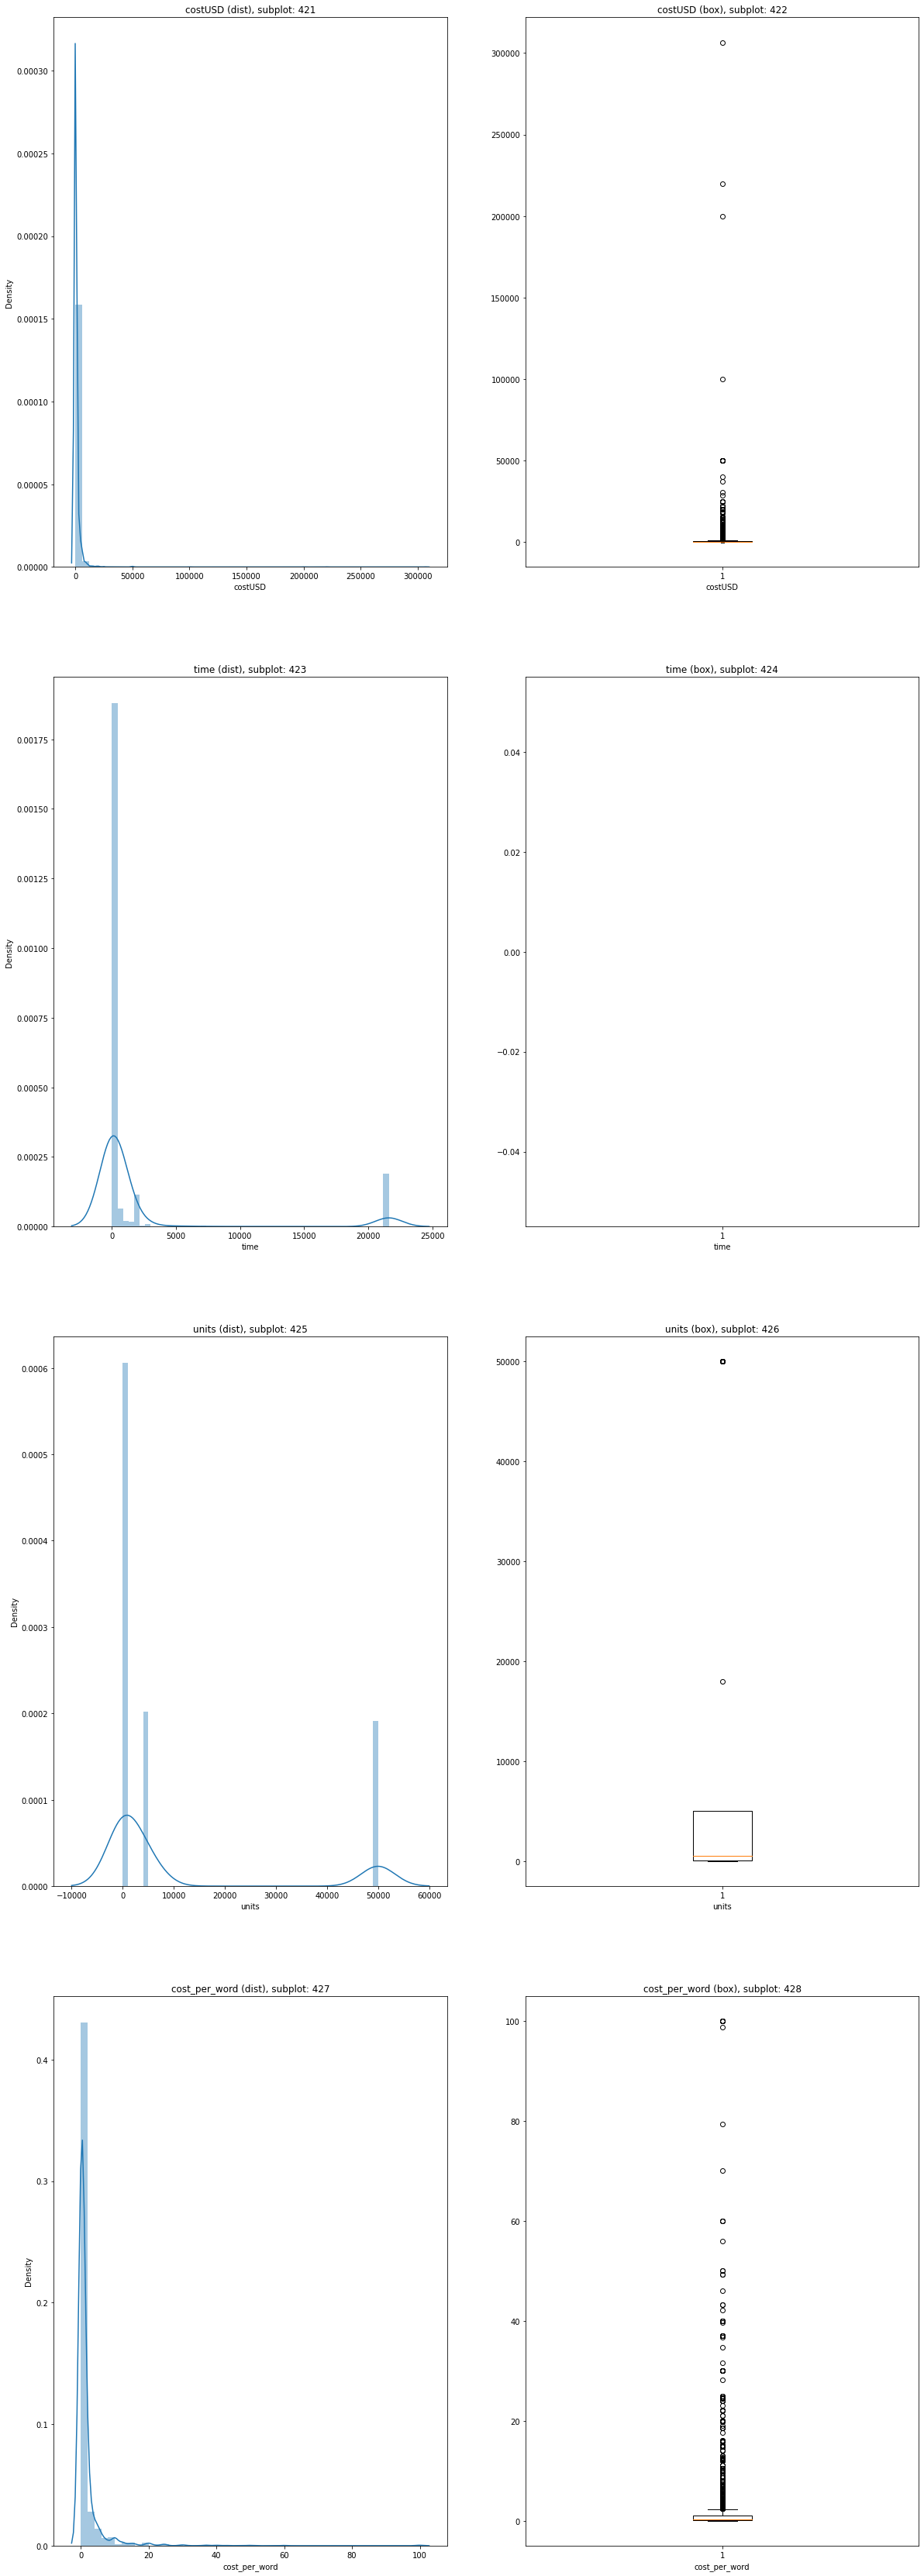

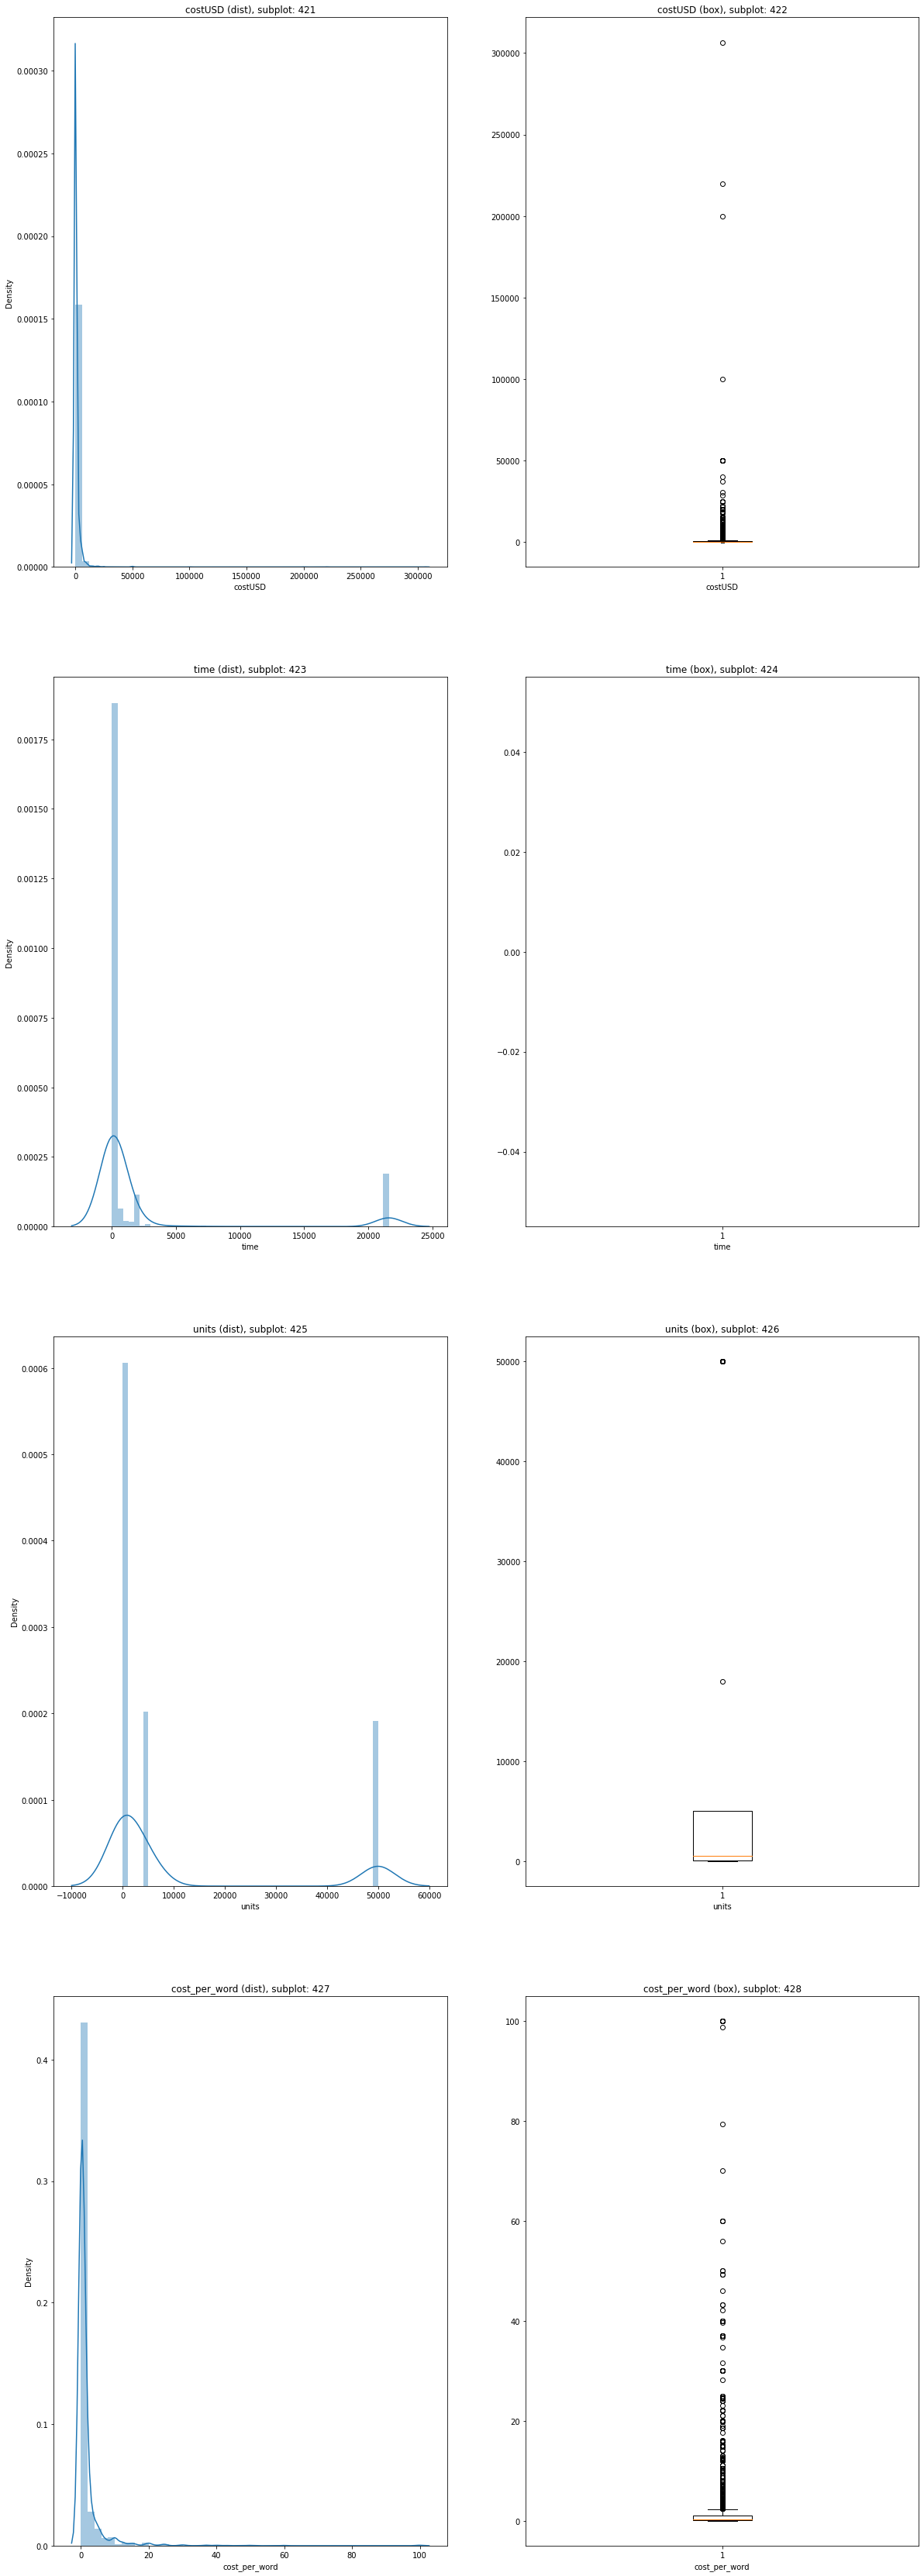

In [32]:
# Plotting distributions and box plots
plot_dist_box(rates_df[numerical_columns])

In [33]:
# Examine high costUSD values

rates_df.sort_values('costUSD', ascending=False).head(15)

,user_id,cost,costUSD,time,units,language_id,cost_per_word
218,1957,306600,306600.00,NaN,50000.0,vulcan,6.132000
85,837,220000,220000.00,NaN,50000.0,vulcan,4.400000
656,6301,200000,200000.00,NaN,50000.0,vulcan,4.000000
480,4569,100000,100000.00,NaN,50000.0,simlish,2.000000
633,6088,50000,50000.00,NaN,50000.0,vulcan,1.000000
1036,10087,50000,50000.00,NaN,50000.0,vulcan,1.000000
1408,1572,50000,50000.00,180.0,5000.0,vulcan,10.000000
1180,11640,50000,50000.00,NaN,50000.0,vulcan,1.000000
846,8354,50000,50000.00,21600.0,50000.0,vulcan,1.000000
23,220,50000,50000.00,NaN,50000.0,vulcan,1.000000


There are only four users with rates above way above 50000 USD. I will remove this outliers since these are not representative of the market reality and can distort all the analysis. 

In [34]:
# Removing costUSD outliers, keeping only rates up to 50000 USD
rates_df = rates_df.loc[rates_df.costUSD <= 50000]

/Users/santiagochiesa/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='language_id', ylabel='count'>

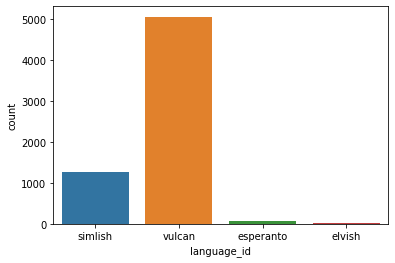

In [35]:
sns.countplot(rates_df.language_id)

In [36]:
# Evaluating correlations for all languages

rates_df[numerical_columns].corr()

,costUSD,time,units,cost_per_word
costUSD,1.000000,0.545251,0.490342,-0.061125
time,0.545251,1.000000,0.938169,-0.102207
units,0.490342,0.938169,1.000000,-0.158682
cost_per_word,-0.061125,-0.102207,-0.158682,1.000000


In [37]:
# Evaluating correlations for 'similish' language

rates_df[numerical_columns].loc[rates_df.language_id=='simlish'].corr()

,costUSD,time,units,cost_per_word
costUSD,1.000000,0.564690,0.567375,-0.075807
time,0.564690,1.000000,0.931642,-0.096957
units,0.567375,0.931642,1.000000,-0.155668
cost_per_word,-0.075807,-0.096957,-0.155668,1.000000


In [38]:
# Evaluating correlations for 'vulcan' language

rates_df[numerical_columns].loc[rates_df.language_id=='vulcan'].corr()

,costUSD,time,units,cost_per_word
costUSD,1.000000,0.542410,0.475716,-0.061125
time,0.542410,1.000000,0.939884,-0.108041
units,0.475716,0.939884,1.000000,-0.166348
cost_per_word,-0.061125,-0.108041,-0.166348,1.000000


In [39]:
# Evaluating correlations for 'esperanto' language

rates_df[numerical_columns].loc[rates_df.language_id=='esperanto'].corr()

,costUSD,time,units,cost_per_word
costUSD,1.000000,0.849050,0.756390,-0.147581
time,0.849050,1.000000,0.930219,-0.164805
units,0.756390,0.930219,1.000000,-0.214989
cost_per_word,-0.147581,-0.164805,-0.214989,1.000000


In [40]:
# Evaluating correlations for 'esperanto' language

rates_df[numerical_columns].loc[rates_df.language_id=='elvish'].corr()

,costUSD,time,units,cost_per_word
costUSD,1.000000,0.241276,0.944217,-0.247570
time,0.241276,1.000000,0.657651,-0.219560
units,0.944217,0.657651,1.000000,-0.251133
cost_per_word,-0.247570,-0.219560,-0.251133,1.000000


As expected, Time and Units (which are strongly correlated) have a possitive correlation with the costUSD. The correlation coefficient varies depending the language. The language data is very imbalanced, most observations belong to "vulcan" and there is very little data on "esperanto" (65 rates) and "elvish" (10 rates).

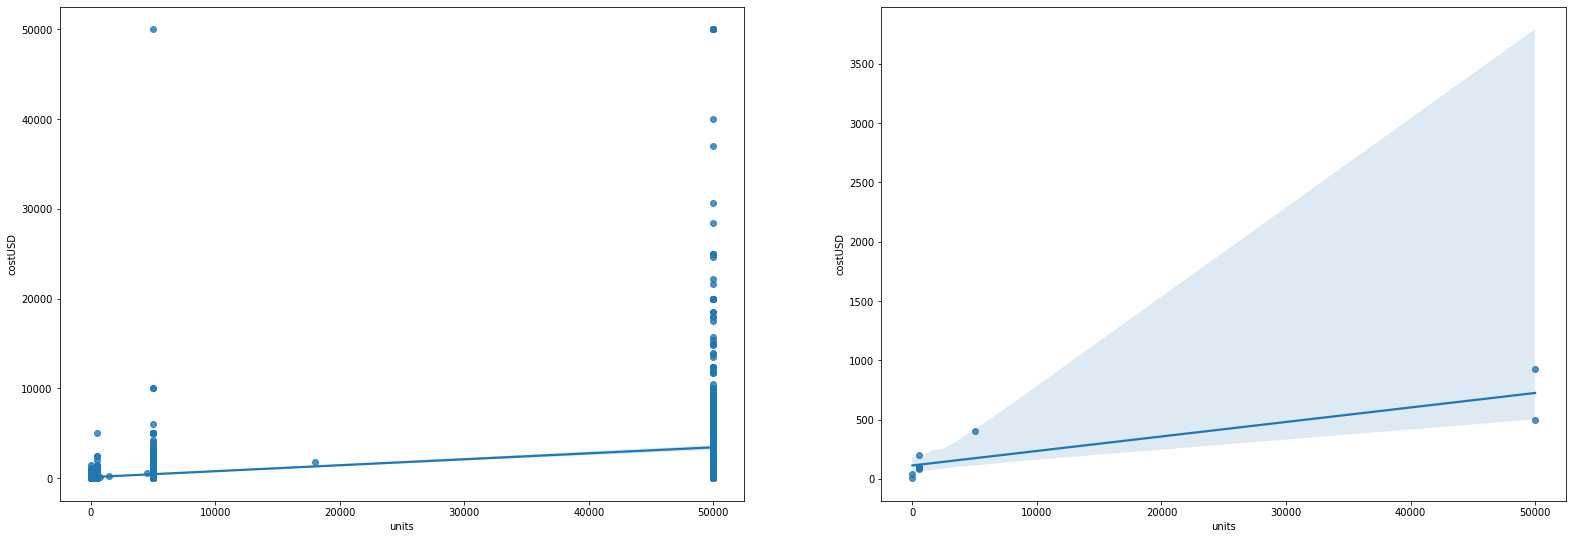

In [41]:
# Plotting relationship between costUSD and units(number of words) for all languages

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='units', y='costUSD', data=rates_df, ci=95)
plt.subplot(2,2,2)
sns.regplot(x='units', y='costUSD', data=rates_df.sample(10, random_state=6), ci=95);

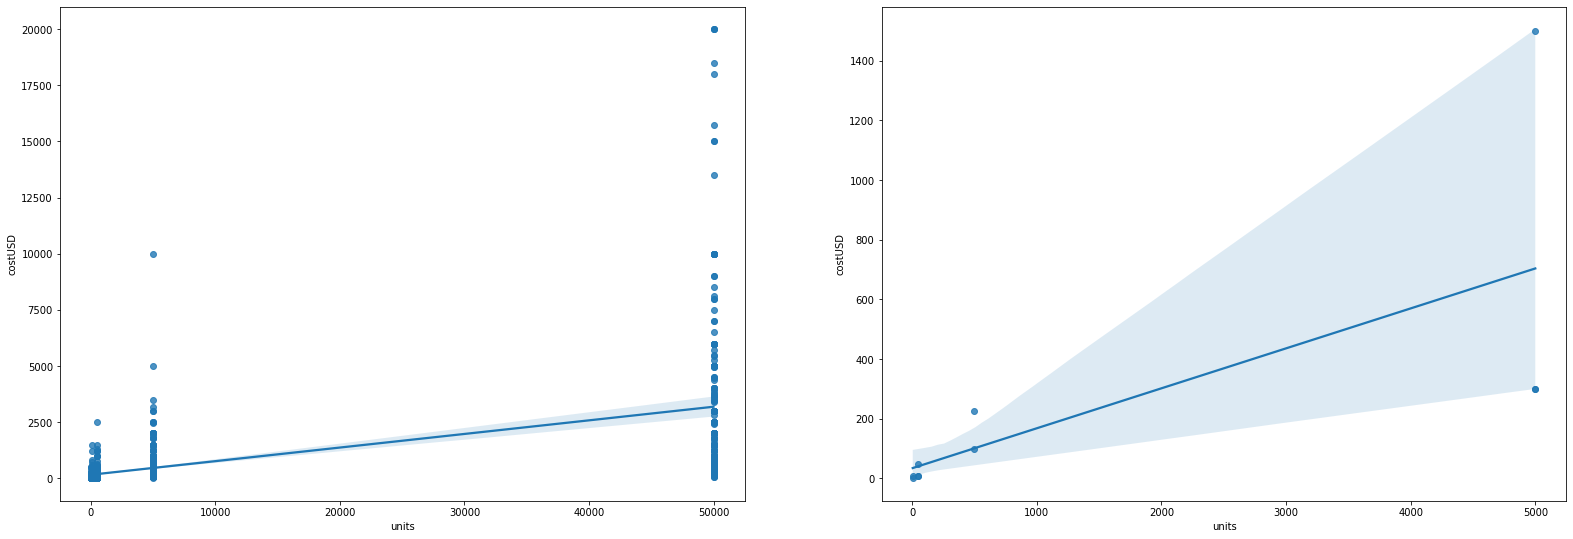

In [42]:
# Plotting relationship between costUSD and units(number of words) for 'similish' language

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='units', y='costUSD', data=rates_df.loc[rates_df.language_id=='simlish'], ci=95)
plt.subplot(2,2,2)
sns.regplot(x='units', y='costUSD', data=rates_df.loc[rates_df.language_id=='simlish'].sample(10, random_state=6), ci=95);

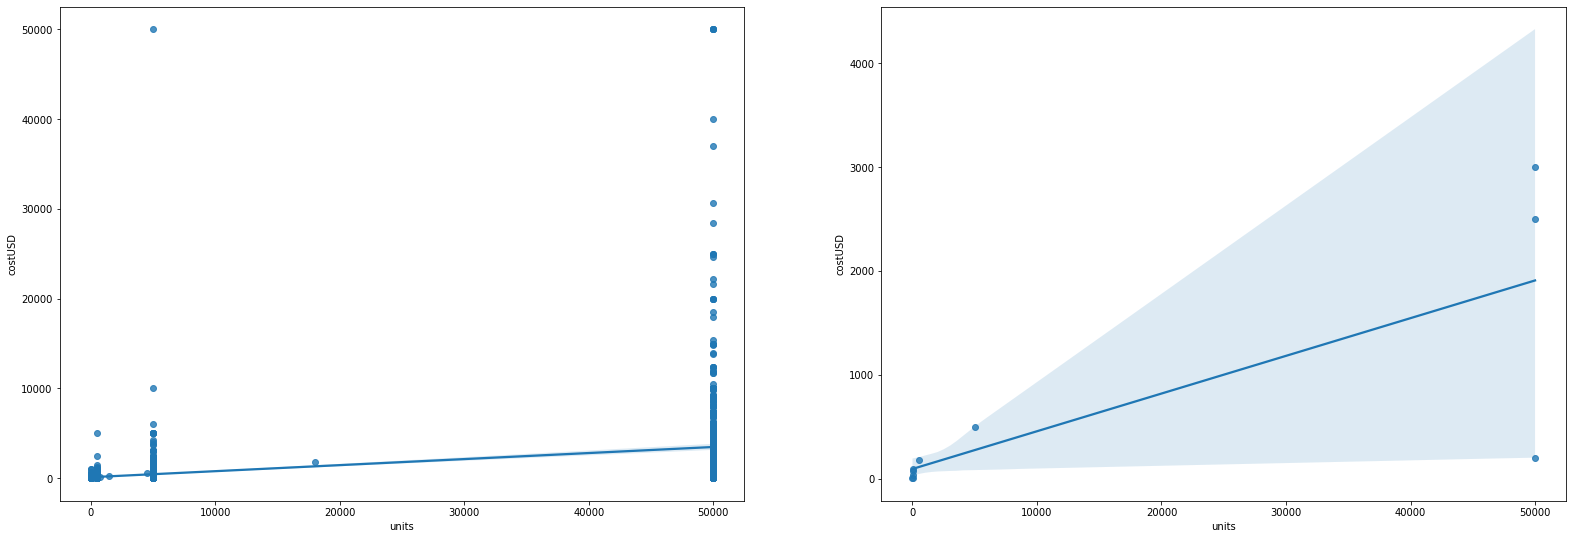

In [43]:
# Plotting relationship between costUSD and units(number of words) for 'vulcan' language

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='units', y='costUSD', data=rates_df.loc[rates_df.language_id=='vulcan'], ci=95)
plt.subplot(2,2,2)
sns.regplot(x='units', y='costUSD', data=rates_df.loc[rates_df.language_id=='vulcan'].sample(10, random_state=6), ci=95);

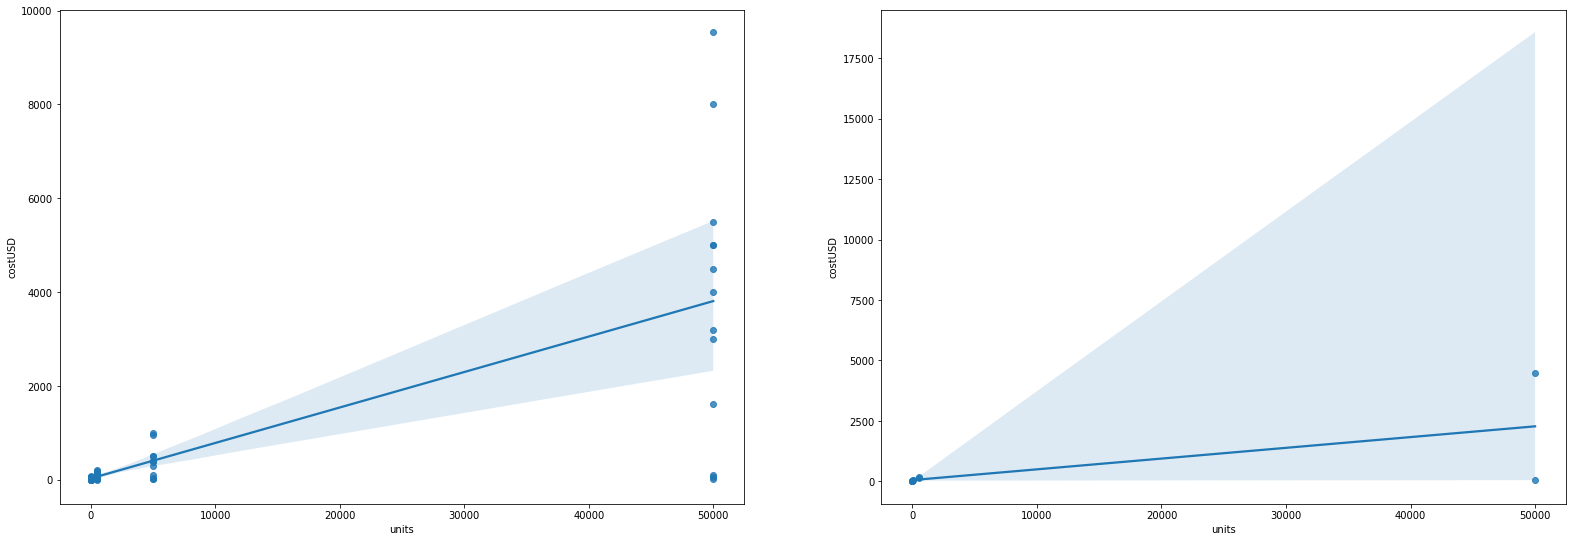

In [44]:
# Plotting relationship between costUSD and units(number of words) for 'esperanto' language

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='units', y='costUSD', data=rates_df.loc[rates_df.language_id=='esperanto'], ci=95)
plt.subplot(2,2,2)
sns.regplot(x='units', y='costUSD', data=rates_df.loc[rates_df.language_id=='esperanto'].sample(10, random_state=6), ci=95);

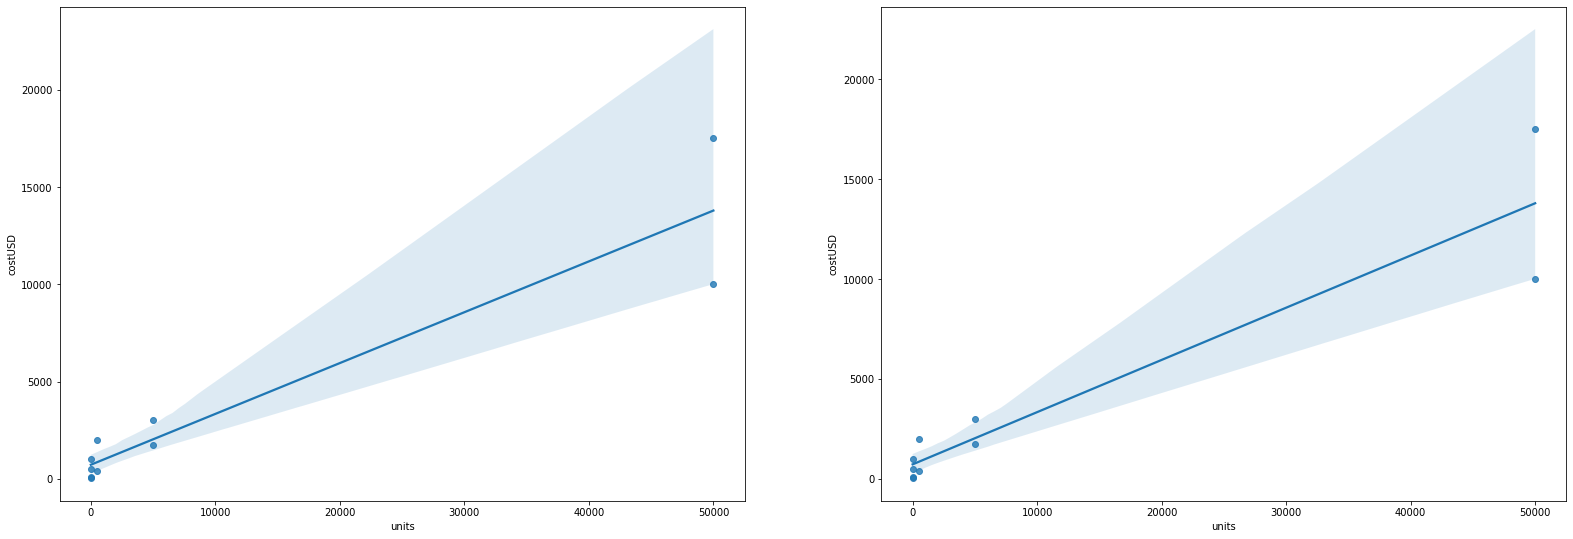

In [45]:
# Plotting relationship between costUSD and units(number of words) for 'elvish' language

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='units', y='costUSD', data=rates_df.loc[rates_df.language_id=='elvish'], ci=95)
plt.subplot(2,2,2)
sns.regplot(x='units', y='costUSD', data=rates_df.loc[rates_df.language_id=='elvish'].sample(10, random_state=6), ci=95);

Scatter plots show that almost exclusively, rates for voice overs of 50,000 words can excalate significantly (over 15,000 USD) 

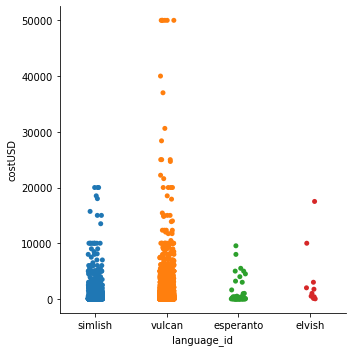

In [46]:
# Plotting costUSD per language
sns.catplot(x='language_id', y='costUSD', data=rates_df)

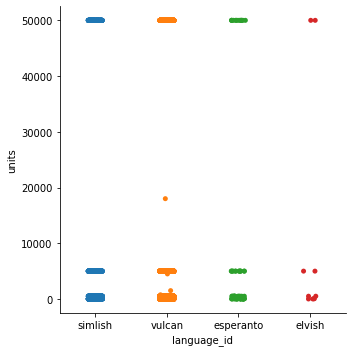

In [47]:
# Plotting units per language
sns.catplot(x='language_id', y='units', data=rates_df)

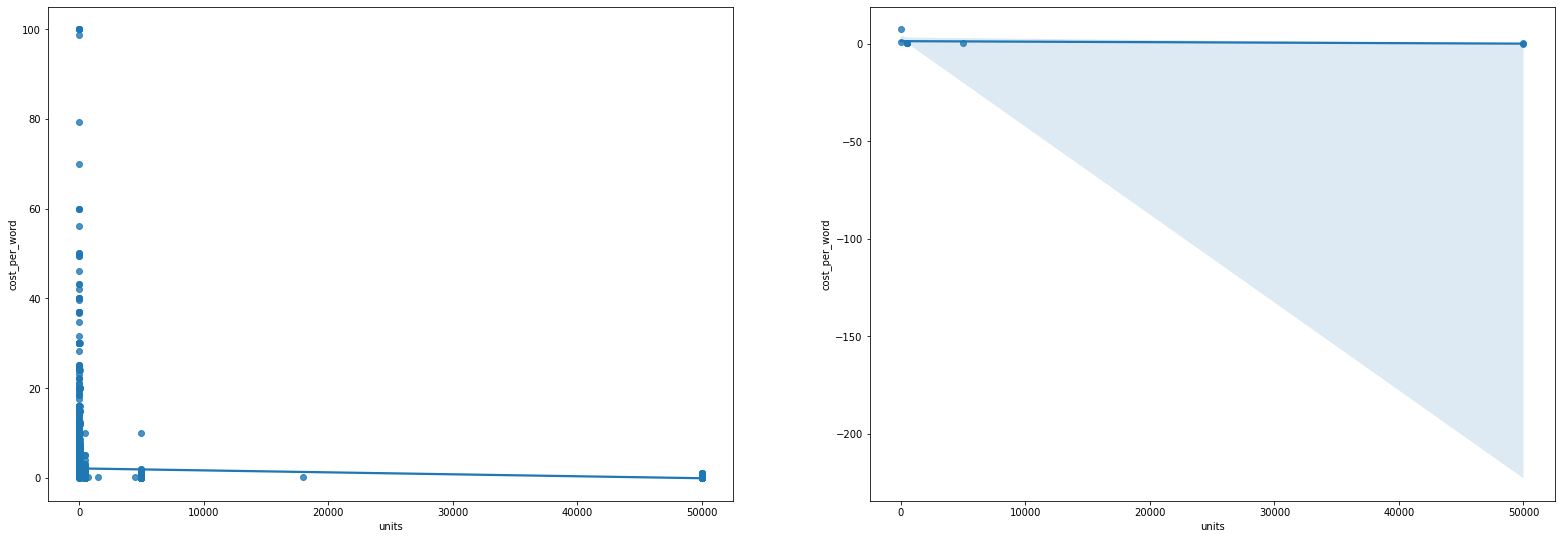

In [48]:
# Plotting relationship between cost_per_word and units(number of words) for all languages

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='units', y='cost_per_word', data=rates_df, ci=95)
plt.subplot(2,2,2)
sns.regplot(x='units', y='cost_per_word', data=rates_df.sample(10, random_state=6), ci=95);

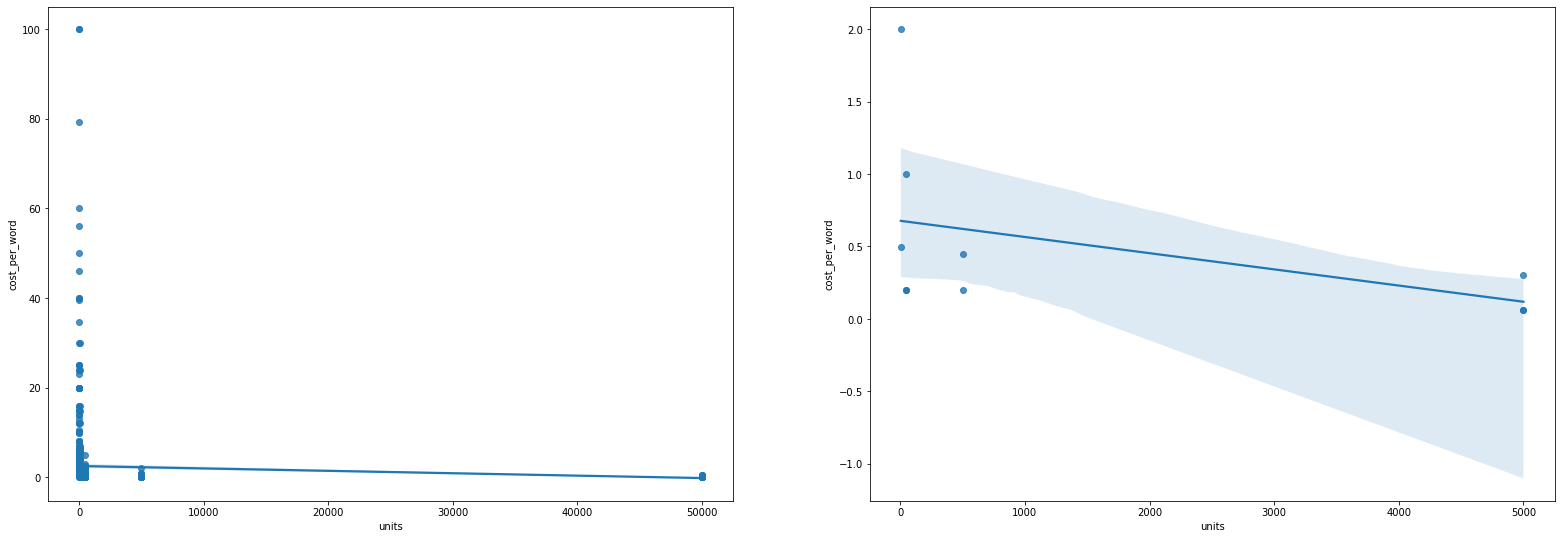

In [51]:
# Plotting relationship between costUSD and units(number of words) for 'similish' language

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='units', y='cost_per_word', data=rates_df.loc[rates_df.language_id=='simlish'], ci=95)
plt.subplot(2,2,2)
sns.regplot(x='units', y='cost_per_word', data=rates_df.loc[rates_df.language_id=='simlish'].sample(10, random_state=6), ci=95);

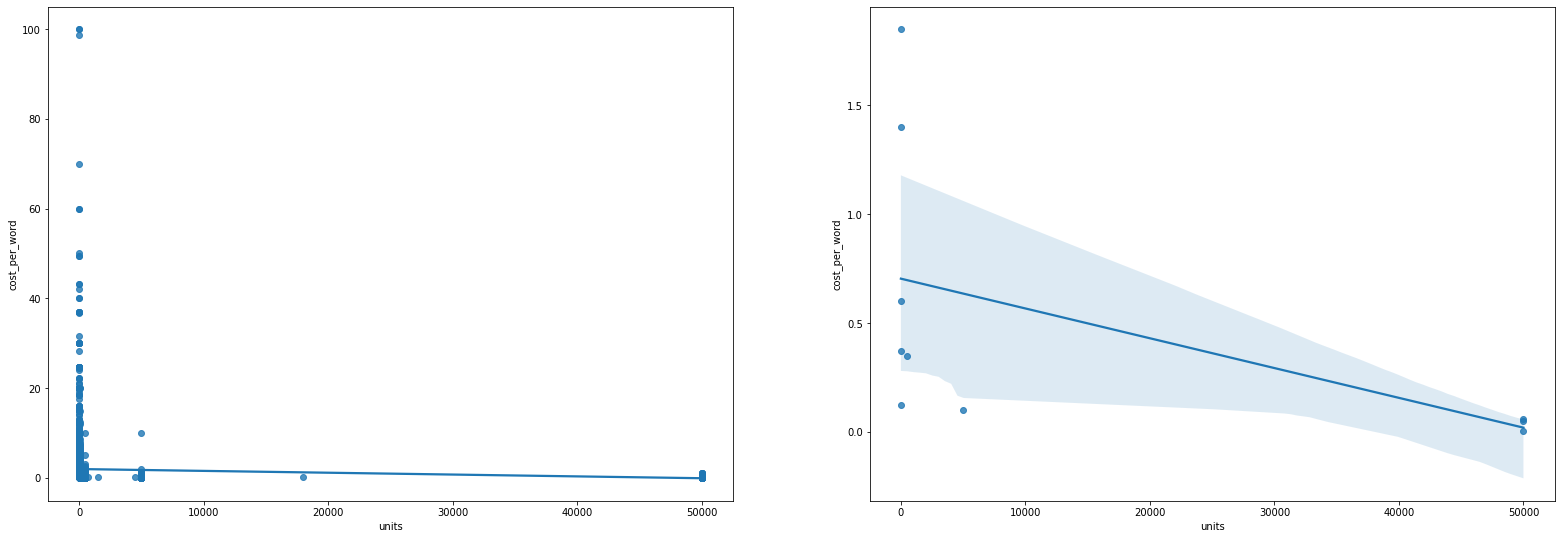

In [56]:
# Plotting relationship between costUSD and units(number of words) for 'vulcan' language

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='units', y='cost_per_word', data=rates_df.loc[rates_df.language_id=='vulcan'], ci=95)
plt.subplot(2,2,2)
sns.regplot(x='units', y='cost_per_word', data=rates_df.loc[rates_df.language_id=='vulcan'].sample(10, random_state=6), ci=95);

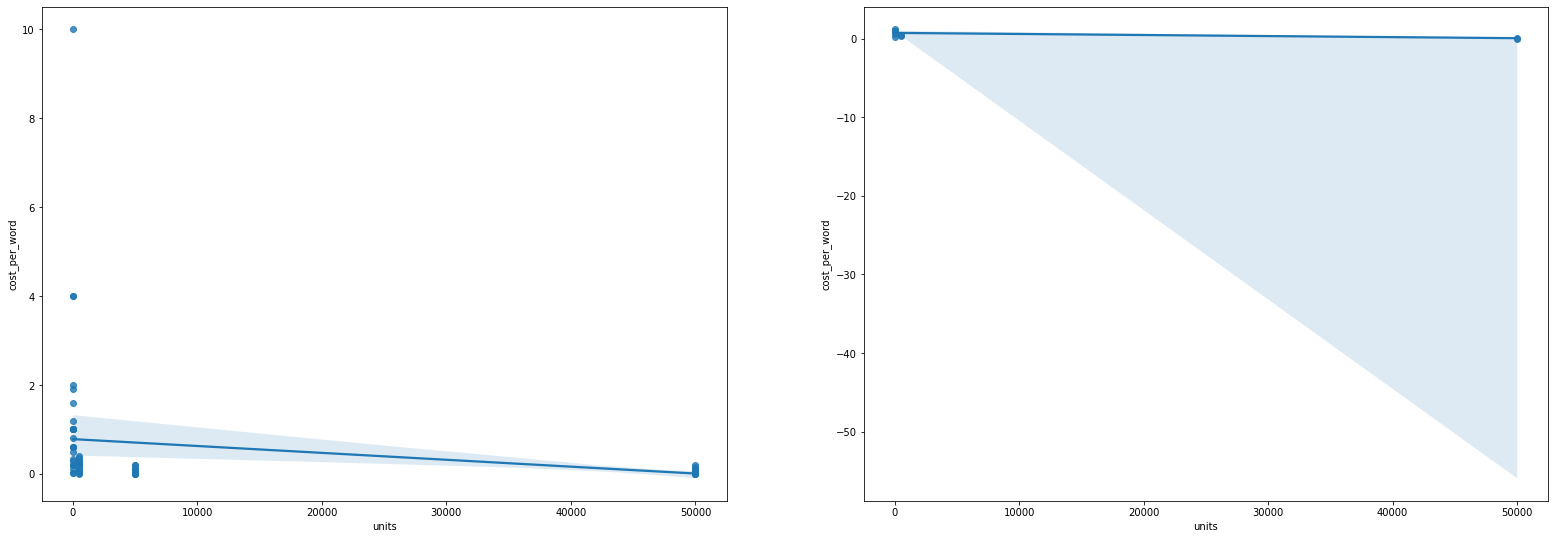

In [58]:
# Plotting relationship between costUSD and units(number of words) for 'esperanto' language

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='units', y='cost_per_word', data=rates_df.loc[rates_df.language_id=='esperanto'], ci=95)
plt.subplot(2,2,2)
sns.regplot(x='units', y='cost_per_word', data=rates_df.loc[rates_df.language_id=='esperanto'].sample(10, random_state=6), ci=95);

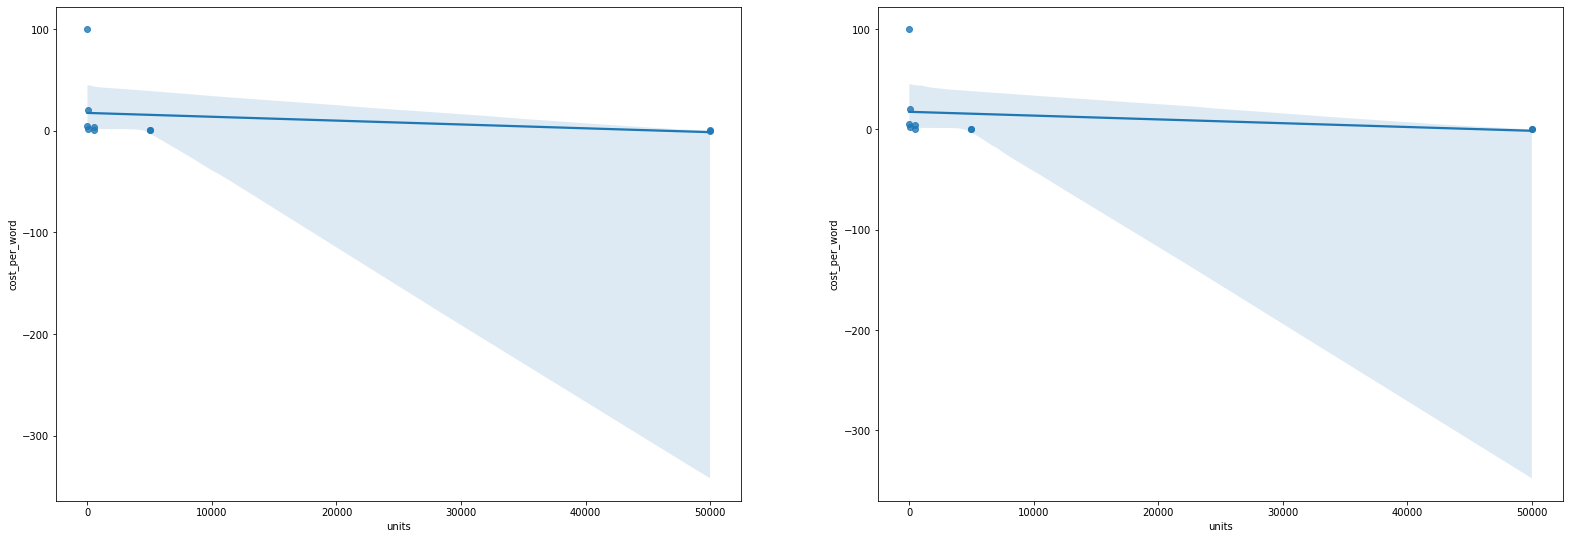

In [54]:
# Plotting relationship between costUSD and units(number of words) for 'elvish' language

plt.figure(figsize=(27,20))
plt.subplot(2,2,1)
sns.regplot(x='units', y='cost_per_word', data=rates_df.loc[rates_df.language_id=='elvish'], ci=95)
plt.subplot(2,2,2)
sns.regplot(x='units', y='cost_per_word', data=rates_df.loc[rates_df.language_id=='elvish'].sample(10, random_state=6), ci=95);

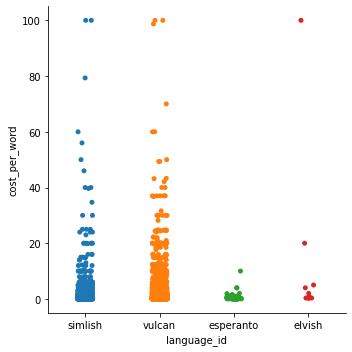

In [49]:
# Plotting units per language
sns.catplot(x='language_id', y='cost_per_word', data=rates_df)

In [50]:
rates_df

,user_id,cost,costUSD,time,units,language_id,cost_per_word
0,6,850,850.00,21600.0,50000.0,simlish,0.017000
1,8,5500,5500.00,0.0,50000.0,vulcan,0.110000
2,12,7000,7000.00,0.0,50000.0,simlish,0.140000
3,24,2500,2500.00,21600.0,50000.0,vulcan,0.050000
4,27,1300,1300.00,NaN,50000.0,vulcan,0.026000
...,...,...,...,...,...,...,...
6385,8070,500,616.85,1800.0,4500.0,vulcan,0.137078
6386,8070,250,308.42,600.0,1500.0,vulcan,0.205613
6387,8070,150.00,185.05,300.0,750.0,vulcan,0.246733
6388,8070,50.00,61.68,60.0,150.0,vulcan,0.411200


### Pricing

Instructions: Pricing requirements

To guarantee upfront, predictable pricing, the following requirements must be met:

Model takes a combination of pricing attributes (language, complexity, etc) and project lengths and
returns a price for any length > 0.

Pros receive the reward they expect.

Bunny Studio keeps at least the 15% of the project price.

Fulfillment types also play a role in the pricing, however we will omit that. 

I'll try a simple aproach based on the cost of word for different languages and word lenghts.

In [59]:
# Creating languages data frames, since cost depends on language
simlish_rates_df = rates_df.loc[rates_df.language_id=='simlish']
vulcan_rates_df = rates_df.loc[rates_df.language_id=='vulcan']
esperanto_rates_df = rates_df.loc[rates_df.language_id=='esperanto']
elvish_rates_df = rates_df.loc[rates_df.language_id=='elvish']

In [63]:
elvish_rates_df

,user_id,cost,costUSD,time,units,language_id,cost_per_word
26,251,10000,10000.0,NaN,50000.0,elvish,0.20
943,9232,17500,17500.0,NaN,50000.0,elvish,0.35
1254,251,3000,3000.0,120.0,5000.0,elvish,0.60
2223,9232,1750,1750.0,5000.0,5000.0,elvish,0.35
2544,251,2000,2000.0,30.0,500.0,elvish,4.00
3513,9232,385,385.0,500.0,500.0,elvish,0.77
3834,251,1000,1000.0,10.0,50.0,elvish,20.00
4803,9232,100,100.0,50.0,50.0,elvish,2.00
5124,251,500,500.0,5.0,5.0,elvish,100.00
6093,9232,25,25.0,5.0,5.0,elvish,5.00


In [68]:
# Computing cost_per_word statistics per language and number of words
simlish_agg = simlish_rates_df.groupby([simlish_rates_df.units]).agg({'cost_per_word': ['count', 'mean', 'median', 'min', 'max']})
vulcan_agg = vulcan_rates_df.groupby([vulcan_rates_df.units]).agg({'cost_per_word': ['count', 'mean', 'median', 'min', 'max']})
esperanto_agg = esperanto_rates_df.groupby([esperanto_rates_df.units]).agg({'cost_per_word': ['count', 'mean', 'median', 'min', 'max']})
elvish_agg = elvish_rates_df.groupby([elvish_rates_df.units]).agg({'cost_per_word': ['count', 'mean', 'median', 'min', 'max']})


In [69]:
simlish_agg

cost_per_word                                  
                count      mean   median     min    max
units                                                  
5.0               254  7.308614  3.23500  0.0380  100.0
50.0              254  1.652902  1.00000  0.0372   30.0
500.0             254  0.398676  0.29744  0.0200    5.0
5000.0            254  0.136084  0.09000  0.0070    2.0
50000.0           244  0.063294  0.04000  0.0009    0.4

In [70]:
vulcan_agg

cost_per_word                                          
                count      mean    median       min         max
units                                                          
5.0              1021  5.633814  2.468000  0.012000  100.000000
50.0             1021  1.231389  0.800000  0.013000   20.000000
75.0                1  0.411200  0.411200  0.411200    0.411200
150.0               1  0.411200  0.411200  0.411200    0.411200
500.0            1021  0.324036  0.246740  0.003900   10.000000
750.0               1  0.246733  0.246733  0.246733    0.246733
1500.0              1  0.205613  0.205613  0.205613    0.205613
4500.0              1  0.137078  0.137078  0.137078    0.137078
5000.0           1021  0.126301  0.083000  0.000800   10.000000
18000.0             1  0.102808  0.102808  0.102808    0.102808
50000.0           961  0.069413  0.040000  0.000100    1.000000

In [84]:
esperanto_agg

cost_per_word                                       
                count      mean   median      min        max
units                                                       
5.0                13  2.055231  1.00000  0.02000  10.000000
50.0               13  0.650323  0.60000  0.01900   1.600000
500.0              13  0.190457  0.20000  0.00572   0.400000
5000.0             13  0.076554  0.07980  0.00160   0.200000
50000.0            13  0.076178  0.07998  0.00018   0.190812

In [86]:
elvish_agg

cost_per_word                              
                count    mean  median   min     max
units                                              
5.0                 2  52.500  52.500  5.00  100.00
50.0                2  11.000  11.000  2.00   20.00
500.0               2   2.385   2.385  0.77    4.00
5000.0              2   0.475   0.475  0.35    0.60
50000.0             2   0.275   0.275  0.20    0.35

In [102]:
# Coding max based pricing model for simlish. 

def simlish_pricing(units):
    
    if units <= 5:
        return units*100
    elif 5 < units <= 50:
        return units*30
    elif 50 < units <= 500:
        return units*5
    elif 500 < units <= 5000:
        return units*2
    elif units > 5000:
        return units*0.4
    

In [103]:
# Coding max based pricing model for vulcan. 

def vulcan_pricing(units):
    
    if units <= 5:
        return units*100
    elif 5 < units <= 50:
        return units*20
    elif 50 < units <= 500:
        return units*10
    elif 500 < units <= 5000:
        return units*10
    elif units > 5000:
        return units*1
    

In [118]:
# Coding max based pricing model for esperanto. 

def esperanto_pricing(units):
    
    if units <= 5:
        return units*10
    elif 5 < units <= 50:
        return units*1.6
    elif 50 < units <= 500:
        return units*0.4
    elif 500 < units <= 5000:
        return units*0.2
    elif units > 5000:
        return units*0.190813
    

In [105]:
# Coding max based pricing model for elvish. 

def elvish_pricing(units):
    
    if units <= 5:
        return units*100
    elif 5 < units <= 50:
        return units*20
    elif 50 < units <= 500:
        return units*4
    elif 500 < units <= 5000:
        return units*0.6
    elif units > 5000:
        return units*0.35
    

In [119]:
# Checking pricing performance

rates_df['min_price_target'] = rates_df.costUSD * 1.15 

rates_df.loc[rates_df.language_id=='simlish', 'pricing'] = rates_df.units.apply(simlish_pricing)*1.15 
rates_df.loc[rates_df.language_id=='vulcan', 'pricing'] = rates_df.units.apply(vulcan_pricing)*1.15 
rates_df.loc[rates_df.language_id=='esperanto', 'pricing'] = rates_df.units.apply(esperanto_pricing)*1.15 
rates_df.loc[rates_df.language_id=='elvish', 'pricing'] = rates_df.units.apply(elvish_pricing)*1.15 

rates_df['pricing_vs_min_target'] = rates_df.pricing - rates_df.min_price_target
rates_df['pricing_exceeds_min'] = 0
rates_df.loc[rates_df['pricing_vs_min_target'] >= 0, 'pricing_exceeds_min'] = 1

In [122]:
# Checking if pricing complies with the rules (pros get their rewards and X gets minimum 15% of the price)
rates_df.pricing_exceeds_min.value_counts()

1    6386
Name: pricing_exceeds_min, dtype: int64

The pricing model complies with the requirements established in the assignment's instructions. That said, from a business perspective, this pricing model might not optimal since expensive pros (outliers) are driving the prices up, which could make the platforms' offering less appealing for clients. 

Given time limitations, I stuck with the most straightforward way of meeting the requirements. It would've been interesting to implement machine learning models and conduct a deeper analysis on how to handle outliers.

### Deliverables

#### Table with suggested prices

In [124]:
suggested_prices = pd.DataFrame([30, 75, 150, 500])
suggested_prices.columns=['words']

In [127]:
suggested_prices['simlish_price'] = suggested_prices.words.apply(simlish_pricing)
suggested_prices['vulcan_price'] = suggested_prices.words.apply(vulcan_pricing)
suggested_prices['esperanto_price'] = suggested_prices.words.apply(esperanto_pricing)
suggested_prices['elvish_price'] = suggested_prices.words.apply(elvish_pricing)


In [128]:
suggested_prices

,words,simlish_price,vulcan_price,esperanto_price,elvish_price
0,30,900,600,48.0,600
1,75,375,750,30.0,300
2,150,750,1500,60.0,600
3,500,2500,5000,200.0,2000


#### Plain English Explanation (300 Words max)

# Define the pricing model for a new subcategory


Now let’s assume that the Head of Product decides to release a new “love letters” subcategory. Because of the novelty, we lack of any sort of data within our databases regarding love letter writers.

How would you approach the lack of data? 

What other pricing approaches would you use to define
a launching price?

Report in max. 300 words how would you proceed in non-technical language.

## Solution